# Loading package

In [1]:
import sys  
sys.path.append('/home/jyx/DePass-main')
import scanpy as sc
from depass.utils import *
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Environment configuration

In [2]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
import os
os.environ['R_HOME'] = '/home/jyx/anaconda3/envs/r-431/lib/R'
fix_seed(2024)    
path = '/home/jyx/DePass-main/outputs/dataset_pbmc3k/run_0.1'
os.mkdir(path) if not os.path.exists(path) else print(f"The directory '{path}' already exists.\n")

The directory '/home/jyx/DePass-main/outputs/dataset_pbmc3k/run_0.1' already exists.



## Loading data

In [3]:
# read data
adata_omics1 = sc.read_h5ad('/data/jyx/sg/dataset_pbmc3k/adata_RNA.h5ad')
adata_omics2 = sc.read_h5ad('/data/jyx/sg/dataset_pbmc3k/adata_ATAC.h5ad')

preprocess_data(adata=adata_omics1,modality='rna')
preprocess_data(adata=adata_omics2,modality='atac')

adata_omics1.obsm['input_feat'] = adata_omics1.obsm['X_norm'].copy()
adata_omics2.obsm['input_feat'] = adata_omics2.obsm['X_lsi'].copy()
data = {'rna': adata_omics1, 'atac': adata_omics2}

# Training the model

In [4]:
from depass.model import DePass
model = DePass(data, data_type='single_cell',device=device,results_file=path)
output = model.train()

The number of input modalities is 2
The data type is single_cell
GPU available: NVIDIA GeForce RTX 4090

 Model training starts...


100%|██████████| 200/200 [00:02<00:00, 92.90it/s] 

Model training finished!



In [5]:
adata = adata_omics1.copy()
adata.obsm['e1'] = model.e1
adata.obsm['e2'] = model.e2
adata.obsm['DePass'] = model.embedding
adata.obsm['z1'] = model.z1
adata.obsm['z2'] = model.z2
adata.obsm['alpha'] = model.alpha 
adata.obsm['z1_aug'] = model.z1_aug
adata.obsm['z2_aug'] = model.z2_aug
adata.write_h5ad(path + '/adata.h5ad')  

# Cross-omics integrative analysis

In [6]:
from depass.utils import *
clustering(adata=adata,n_clusters=12,key='DePass',add_key='DePass',method='mclust',use_pca=True)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


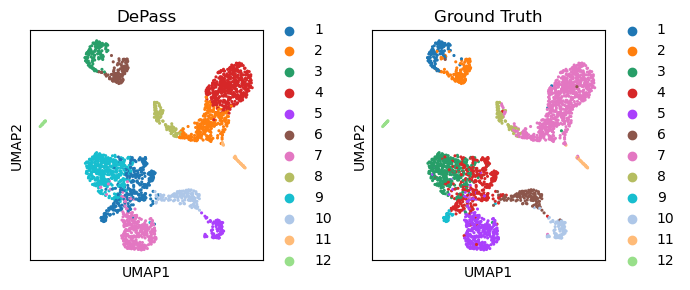

In [7]:
# visualization
import matplotlib.pyplot as plt
adata.obs['Y'] = adata.obs['Y'].astype('category')
fig, ax_list = plt.subplots(1, 2, figsize=(7, 3))
sc.pp.neighbors(adata, use_rep='DePass', n_neighbors=10)
sc.tl.umap(adata)
sc.pl.umap(adata, color='DePass', ax=ax_list[0], title='DePass', s=20, show=False)
sc.pl.umap(adata, color='Y', ax=ax_list[1], title='Ground Truth', s=20, show=False)

plt.tight_layout()
plt.show()

In [8]:
from depass.utils import super_eval
re = super_eval(adata.obs['DePass'],adata.obs['Y'])
print(re)
pd.DataFrame(list(re.items()), columns=['metric', 'Value']).to_csv(path + '/re.csv', sep='\t', index=True, float_format='%.6f')

{'AMI': 0.8081553856044649, 'NMI': 0.8105373678731463, 'ARI': 0.6739207360135475, 'Homogeneity': 0.8497699821303678, 'V-measure': 0.8105373678731462, 'Mutual Information': 1.7158867850559678}
